In [24]:
%pip install --upgrade pip

%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [27]:
## Casey Data Preprocessing ##
df_train.head()
print(df_train['age_upon_intake'].unique())

# drop the rows with missing values in the 'age_upon_intake' column
df_train[df_train['age_upon_intake'].isna()]
df_train = df_train.dropna(subset=['age_upon_intake'])

df_train['sex_upon_intake'].unique()
df_train[df_train['sex_upon_intake'].isna()]['sex_upon_intake'] = 'Unknown'

# Function to convert age strings into years
def convert_age(age_str):
    # Expecting age_str in the format "<number> <unit>"
    # e.g., "2 years", "8 months", "3 weeks", "15 days"
    parts = age_str.split()
    if len(parts) != 2:
        return None
    try:
        num = float(parts[0])
    except ValueError:
        return None
    unit = parts[1].lower()
    if "year" in unit:
        return num
    elif "month" in unit:
        return num / 12
    elif "week" in unit:
        return num / 52
    elif "day" in unit:
        return num / 365
    else:
        return None

df_train['age_upon_intake'] = df_train['age_upon_intake'].apply(convert_age)

df_train[df_train['age_upon_intake'] < 0].head()



['8 years' '11 months' '2 years' '6 years' '6 months' '4 weeks' '5 months'
 '4 years' '1 month' '14 years' '2 weeks' '1 week' '2 months' '18 years'
 '9 years' '4 months' '1 day' '1 year' '3 years' '5 years' '8 months'
 '6 days' '7 years' '3 months' '12 years' '3 weeks' '9 months' '10 years'
 '10 months' '7 months' '0 years' '1 weeks' '5 days' '17 years' '2 days'
 '11 years' '4 days' '3 days' '15 years' '13 years' '5 weeks' '16 years'
 '19 years' '-1 years' '20 years' '-4 years' '22 years' nan '24 years']


C:\Users\nneom\AppData\Local\Temp\ipykernel_25572\116464133.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[df_train['sex_upon_intake'].isna()]['sex_upon_intake'] = 'Unknown'


,id,name,intake_time,found_location,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,color,outcome_time,date_of_birth,outcome_type
6828,A725472,Rascal,02/26/2019 11:25:00 AM,Austin (TX),Owner Surrender,Normal,Dog,Neutered Male,-1.0,Chihuahua Shorthair Mix,White/Brown,07/24/2016 03:54:00 PM,04/29/2020,Adoption
30959,A783723,Pina,11/05/2018 11:00:00 AM,3108 Crownover Street in Austin (TX),Stray,Normal,Cat,Intact Female,-4.0,Domestic Shorthair,White/Orange,11/12/2018 11:53:00 AM,02/07/2023,Adoption
44133,A797495,Ace,06/14/2019 11:34:00 AM,6814 East Riverside Drive in Austin (TX),Stray,Normal,Dog,Neutered Male,-1.0,Cairn Terrier,Black/Tan,06/17/2021 11:46:00 AM,12/16/2020,Transfer
70654,A753893,Chato,06/26/2015 04:30:00 PM,6709 Ponca Street in Austin (TX),Stray,Normal,Dog,Intact Male,-1.0,American Bulldog Mix,White/Brown,09/10/2017 12:00:00 AM,07/12/2016,Transfer


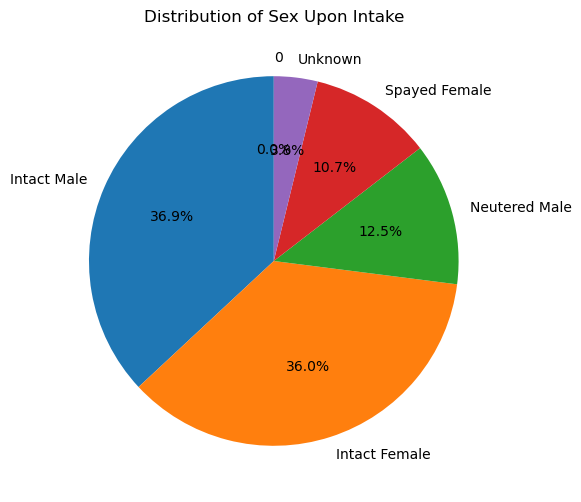

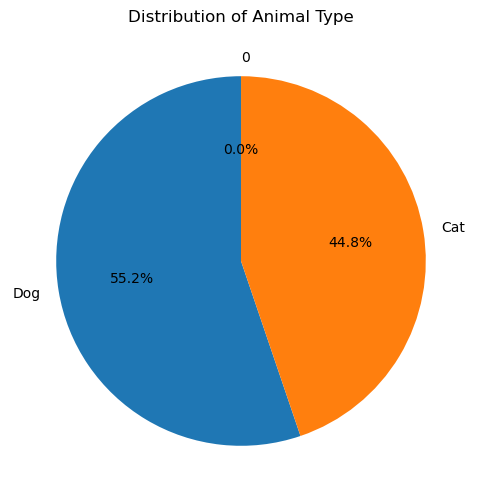

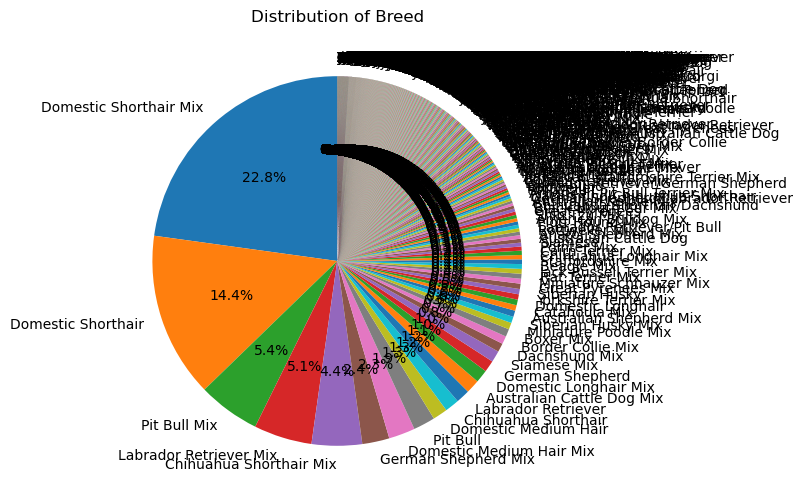

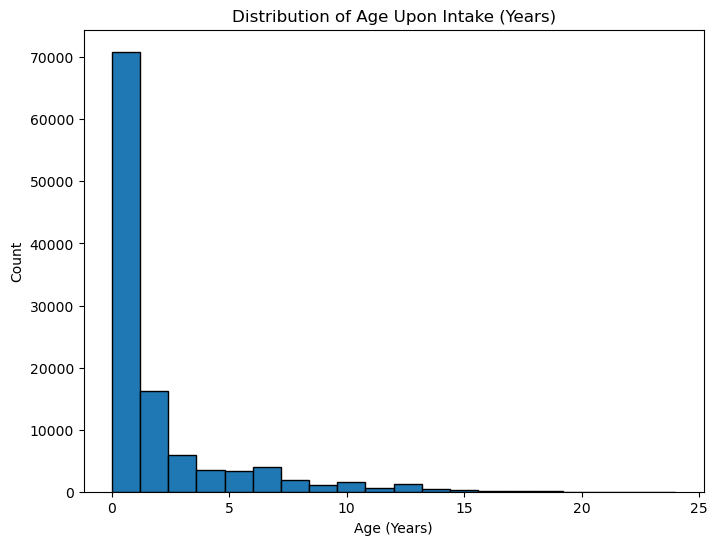

In [28]:
# set negative ages to 0
df_train[df_train['age_upon_intake'] < 0] = 0

# Pie chart for 'sex_upon_intake'
plt.figure(figsize=(6,6))
df_train['sex_upon_intake'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Sex Upon Intake")
plt.ylabel('')
plt.show()

# Pie chart for 'animal_type'
plt.figure(figsize=(6,6))
df_train['animal_type'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Animal Type")
plt.ylabel('')
plt.show()

# Pie chart for 'breed'
plt.figure(figsize=(6,6))
df_train['breed'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Breed")
plt.ylabel('')
plt.show()

# Bar chart (histogram) for 'age_in_years'
plt.figure(figsize=(8,6))
plt.hist(df_train['age_upon_intake'].dropna(), bins=20, edgecolor='black')
plt.title("Distribution of Age Upon Intake (Years)")
plt.xlabel("Age (Years)")
plt.ylabel("Count")
plt.show()

In [29]:
# Count the frequency of each breed
breed_counts = df_train['breed'].value_counts()

rare_breeds = breed_counts[breed_counts <= 3].index

# Filter the DataFrame for records with these rare breeds
rare_records = df_train[df_train['breed'].isin(rare_breeds)]

# Get the number of such records
rare_count = rare_records.shape[0]
print("Number of rare breeds:", rare_count)

Number of rare breeds: 2329


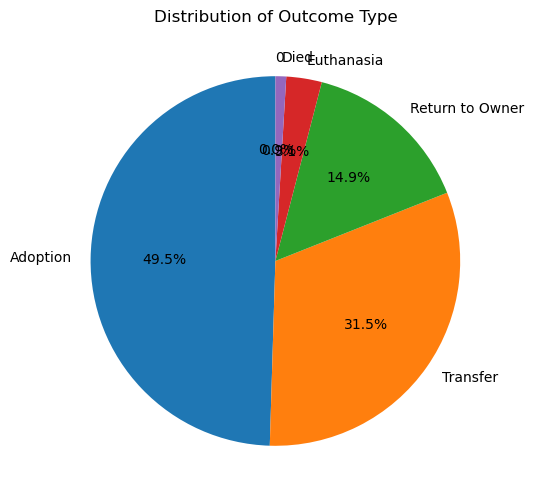

In [30]:
# Pie chart for 'outcome_type'
plt.figure(figsize=(6,6))
df_train['outcome_type'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Outcome Type")
plt.ylabel('')
plt.show()

In [31]:
df_train.describe()

,age_upon_intake
count,111156.000000
mean,1.906149
std,2.865817
min,0.000000
25%,0.083333
50%,1.000000
75%,2.000000
max,24.000000


In [32]:
## Data Preprocessing ##
'''
print('records with missing names:', df_train['name'].isna().sum())  

print('records that are blank or has numbers:', non_alpha_values.sum()) # does not wrok but you get the idea. fix pls
'''

"\nprint('records with missing names:', df_train['name'].isna().sum())  \n\nprint('records that are blank or has numbers:', non_alpha_values.sum()) # does not wrok but you get the idea. fix pls\n"

In [33]:
# Rebecca's slay data exploration block /ᐠ - ˕ -マ intake time, color, outcome time, date of birth

train_sample = df_train.sample(n=5000)

# feature engineering 

# calculating DAYS in shelter
train_sample["days_in_shelter"] = (pd.to_datetime(train_sample["outcome_time"]) - pd.to_datetime(train_sample["intake_time"])).dt.total_seconds() / 86400
# get rid of invalid rows
train_sample = train_sample.dropna(subset=["intake_time", "outcome_time"])
train_sample = train_sample[train_sample["intake_time"] < train_sample["outcome_time"]]

# calculating the primary color of the animal in both cats and dogs 
train_sample["primary_color"] = train_sample["color"].str.split("/, ").str[0]

# age group of cats


C:\Users\nneom\AppData\Local\Temp\ipykernel_25572\2740429093.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_sample["days_in_shelter"] = (pd.to_datetime(train_sample["outcome_time"]) - pd.to_datetime(train_sample["intake_time"])).dt.total_seconds() / 86400
C:\Users\nneom\AppData\Local\Temp\ipykernel_25572\2740429093.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_sample["days_in_shelter"] = (pd.to_datetime(train_sample["outcome_time"]) - pd.to_datetime(train_sample["intake_time"])).dt.total_seconds() / 86400


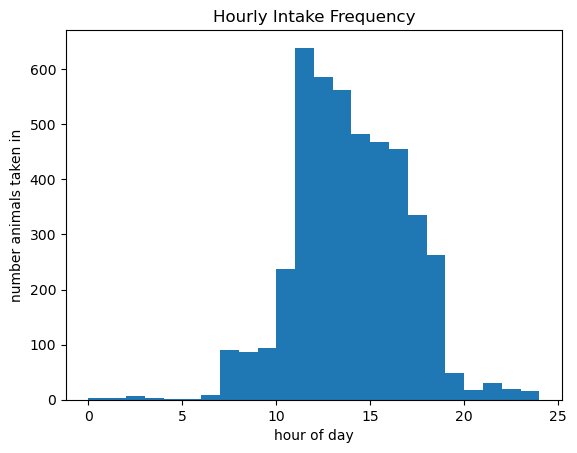

In [34]:
# what time of day are animals brought in? 
train_sample['intake_hour'] = pd.to_datetime(df_train['intake_time'], format="%m/%d/%Y %I:%M:%S %p", errors='coerce').dt.hour
plt.hist(train_sample["intake_hour"], bins=24, range=(0, 24))
plt.xlabel("hour of day")
plt.ylabel("number animals taken in")
plt.title("Hourly Intake Frequency") 
plt.show()

C:\Users\nneom\AppData\Local\Temp\ipykernel_25572\2410007291.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cats_sample["primary_color"] = cats_sample["primary_color"].apply(lambda x: x if x in top_colors else "Other")


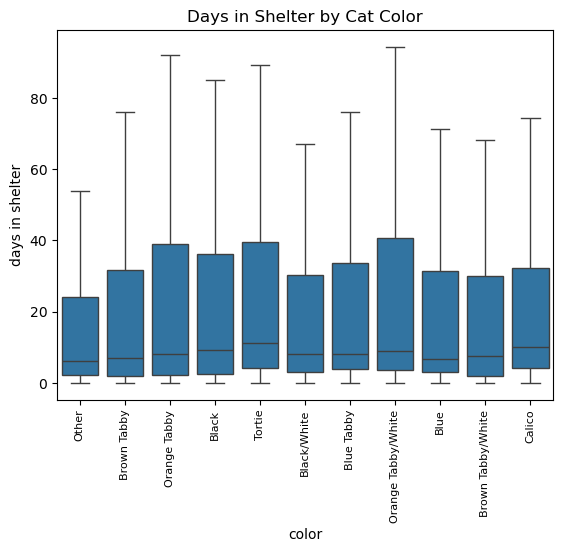

In [35]:
# CATS!
cats_sample = train_sample[train_sample["animal_type"] == "Cat"]

# narrow down to top colors for better visualization
top_colors = cats_sample["primary_color"].value_counts().nlargest(10).index
cats_sample["primary_color"] = cats_sample["primary_color"].apply(lambda x: x if x in top_colors else "Other")

# get rid of invalid ones 
cats_sample = cats_sample[cats_sample["days_in_shelter"] > 0]

# plot!
sns.boxplot(data=cats_sample, x="primary_color", y="days_in_shelter", showfliers=False)
plt.xlabel("color")
plt.xticks(rotation=90, fontsize=8)
plt.ylabel("days in shelter")
plt.title("Days in Shelter by Cat Color")
plt.show()

C:\Users\nneom\AppData\Local\Temp\ipykernel_25572\2383781449.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dogs_sample["primary_color"] = dogs_sample["primary_color"].apply(lambda x: x if x in top_colors else "Other")


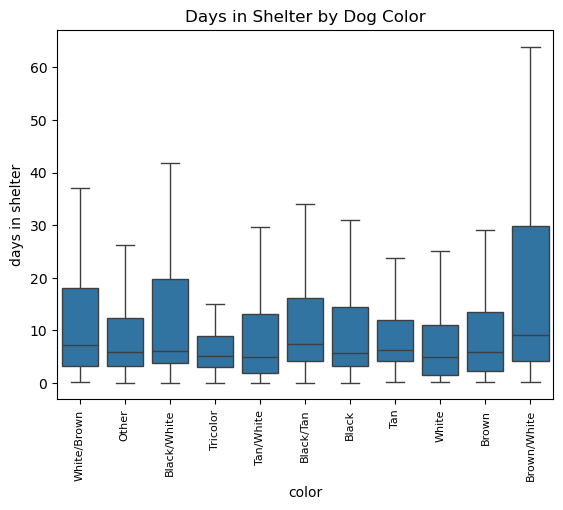

In [36]:
# dogs
dogs_sample = train_sample[train_sample["animal_type"] == "Dog"]

# only save top colors
top_colors = dogs_sample["primary_color"].value_counts().nlargest(10).index
dogs_sample["primary_color"] = dogs_sample["primary_color"].apply(lambda x: x if x in top_colors else "Other")

# getting rid of invalid ones 
dogs_sample = dogs_sample[dogs_sample["days_in_shelter"] > 0]

sns.boxplot(data=dogs_sample, x="primary_color", y="days_in_shelter", showfliers=False)
plt.xlabel("color")
plt.xticks(rotation=90, fontsize=8)
plt.ylabel("days in shelter")
plt.title("Days in Shelter by Dog Color")
plt.show()

C:\Users\nneom\AppData\Local\Temp\ipykernel_25572\623366566.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  adopted_cats["age_when_adopted"] = (pd.to_datetime(adopted_cats["outcome_time"]) - pd.to_datetime(adopted_cats["date_of_birth"])).dt.days / 365
C:\Users\nneom\AppData\Local\Temp\ipykernel_25572\623366566.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adopted_cats["age_when_adopted"] = (pd.to_datetime(adopted_cats["outcome_time"]) - pd.to_datetime(adopted_cats["date_of_birth"])).dt.days / 365
C:\Users\nneom\AppData\Local\Temp\ipykernel_25572\623366566.py:16: SettingWithCopyWarning: 
A value is t

([<matplotlib.patches.Wedge at 0x1ee88b9c830>,
 [Text(-0.957733425945459, 0.541060703458285, 'Kitten'),
  Text(0.9258578157526969, -0.5939590095365549, 'Adult'),
  Text(1.098266227808133, -0.06173566923662797, 'Senior')],
 [Text(-0.5224000505157048, 0.2951240200681554, '83.6%'),
  Text(0.5050133540469255, -0.32397764156539355, '14.6%'),
  Text(0.5990543060771634, -0.03367400140179707, '1.8%')])

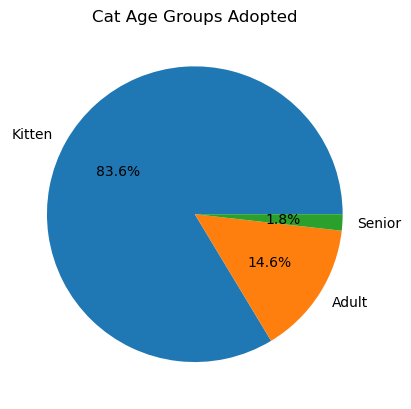

In [37]:
# cats adoptive sample
adopted_cats = cats_sample[cats_sample["outcome_type"] == "Adoption"]

# cat age groups
adopted_cats["age_when_adopted"] = (pd.to_datetime(adopted_cats["outcome_time"]) - pd.to_datetime(adopted_cats["date_of_birth"])).dt.days / 365

def cat_age_groups(age):
    if pd.isna("age"):  
        return "Unknown"
    elif age > 10:
        return "Senior"
    elif age > 2:
        return "Adult"
    return "Kitten"

adopted_cats["age_group_when_adopted"] = adopted_cats["age_when_adopted"].apply(cat_age_groups)

adopt_age_group_counts = adopted_cats["age_group_when_adopted"].value_counts()

plt.title("Cat Age Groups Adopted")
plt.pie(adopt_age_group_counts, labels=adopt_age_group_counts.index, autopct='%1.1f%%')

C:\Users\nneom\AppData\Local\Temp\ipykernel_25572\722849970.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  adopted_dogs["age_when_adopted"] = (pd.to_datetime(adopted_dogs["outcome_time"]) - pd.to_datetime(adopted_dogs["date_of_birth"])).dt.days / 365
C:\Users\nneom\AppData\Local\Temp\ipykernel_25572\722849970.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adopted_dogs["age_when_adopted"] = (pd.to_datetime(adopted_dogs["outcome_time"]) - pd.to_datetime(adopted_dogs["date_of_birth"])).dt.days / 365


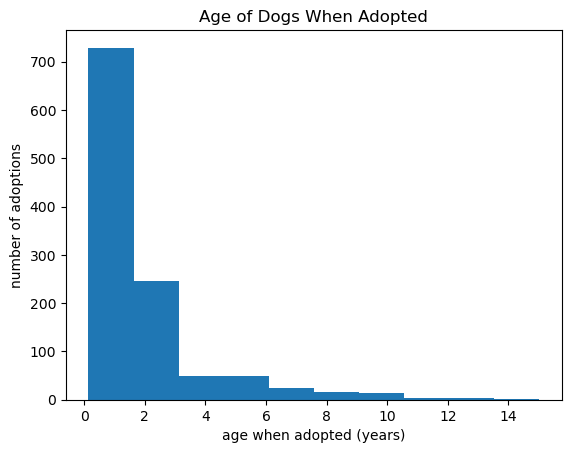

Text(0.5, 1.0, 'Age of Cats When Adopted')

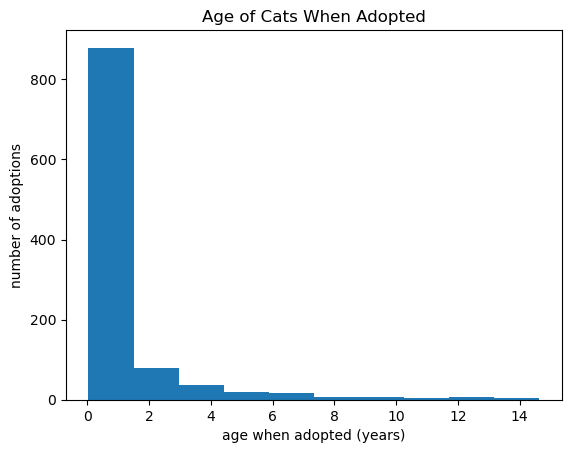

In [38]:
# age in MONTHS that are most popular for adoption - cats and dogs 
adopted_dogs = dogs_sample.dropna(subset="outcome_type")
adopted_dogs = dogs_sample[dogs_sample["outcome_type"] == "Adoption"]
adopted_dogs["age_when_adopted"] = (pd.to_datetime(adopted_dogs["outcome_time"]) - pd.to_datetime(adopted_dogs["date_of_birth"])).dt.days / 365

plt.hist(adopted_dogs["age_when_adopted"])
plt.xlabel("age when adopted (years)")
plt.ylabel("number of adoptions")
plt.title("Age of Dogs When Adopted")
plt.show()

plt.hist(adopted_cats["age_when_adopted"])
plt.xlabel("age when adopted (years)")
plt.ylabel("number of adoptions")
plt.title("Age of Cats When Adopted")

intake_type
Stray                 82159
Owner Surrender       21446
Public Assist          6131
Abandoned              1233
Euthanasia Request      182
0                         4
Wildlife                  1
Name: count, dtype: int64
0


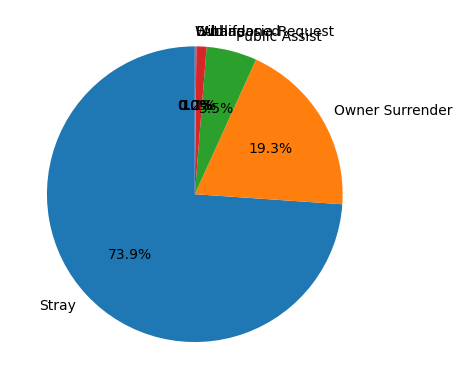

In [39]:
# Nneoma's data visualation

# I am going to look at the Intake Type

print(df_train['intake_type'].value_counts())
plt.pie(df_train['intake_type'].value_counts(), labels=df_train['intake_type'].value_counts().index, autopct='%1.1f%%', startangle=90)

print(df_train['intake_type'].isna().sum())

In [40]:
df_cat = df_train[df_train['animal_type'] == 'Cat']
df_dog = df_train[df_train['animal_type'] == 'Dog']

CAT INTAKE TYPES
intake_type
Stray                 39062
Owner Surrender        9142
Public Assist          1009
Abandoned               523
Euthanasia Request       42
Name: count, dtype: int64


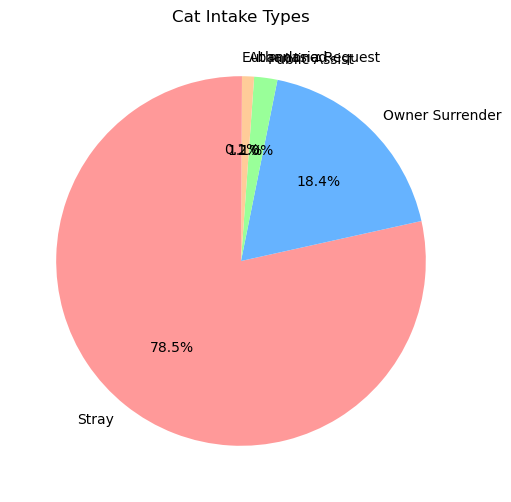

0
DOG INTAKE TYPES
intake_type
Stray                 43097
Owner Surrender       12304
Public Assist          5122
Abandoned               710
Euthanasia Request      140
Wildlife                  1
Name: count, dtype: int64


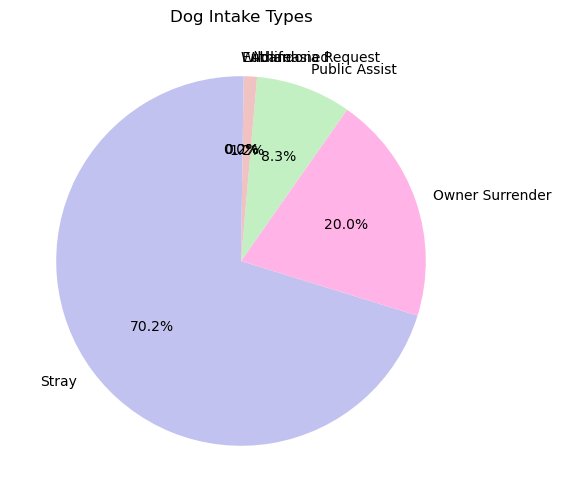

0


In [41]:
# Define custom color palettes
cat_colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
dog_colors = ['#c2c2f0','#ffb3e6','#c2f0c2','#f0c2c2']

# CAT INTAKE TYPES
print('CAT INTAKE TYPES')
print(df_cat['intake_type'].value_counts())
plt.figure(figsize=(6, 6))  # Optional: control pie size
plt.pie(df_cat['intake_type'].value_counts(), 
        labels=df_cat['intake_type'].value_counts().index, 
        autopct='%1.1f%%', 
        startangle=90,
        colors=cat_colors)
plt.title('Cat Intake Types')
plt.show()

print(df_cat['intake_type'].isna().sum())


# DOG INTAKE TYPES
print('DOG INTAKE TYPES')
print(df_dog['intake_type'].value_counts())
plt.figure(figsize=(6, 6))
plt.pie(df_dog['intake_type'].value_counts(), 
        labels=df_dog['intake_type'].value_counts().index, 
        autopct='%1.1f%%', 
        startangle=90,
        colors=dog_colors)
plt.title('Dog Intake Types')
plt.show()

print(df_dog['intake_type'].isna().sum())

intake_condition
Normal        95005
Injured        6394
Sick           4295
Nursing        2957
Neonatal       1240
Aged            373
Medical         298
Other           247
Pregnant        111
Feral           104
Med Attn         48
Behavior         42
Unknown          12
Neurologic       10
Med Urgent        7
Parvo             5
0                 4
Space             2
Agonal            1
Congenital        1
Name: count, dtype: int64
0


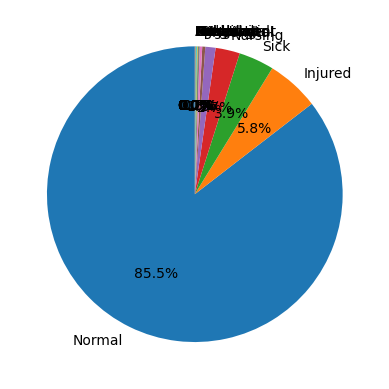

In [42]:
# INTAKE CONDITION

df_train['intake_condition'].unique() # 
print(df_train['intake_condition'].value_counts())
plt.pie(df_train['intake_condition'].value_counts(), labels=df_train['intake_condition'].value_counts().index, autopct='%1.1f%%', startangle=90)

print(df_train['intake_condition'].isna().sum())

CAT INTAKE CONDITIONS
intake_condition
Normal        41031
Injured        3072
Sick           2338
Nursing        2018
Neonatal        923
Medical         103
Feral            95
Other            77
Aged             58
Pregnant         29
Med Attn         17
Unknown           5
Neurologic        5
Med Urgent        2
Space             2
Behavior          2
Agonal            1
Name: count, dtype: int64


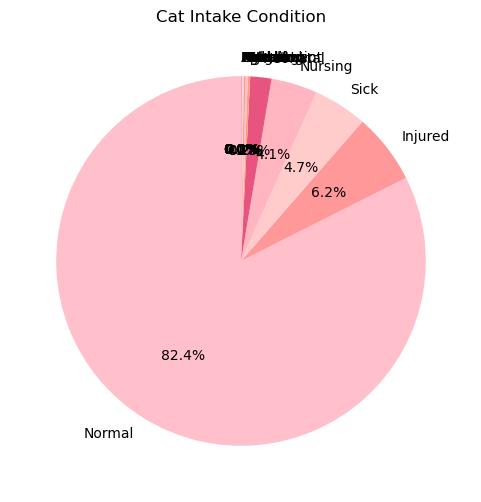

Missing: 0
DOG INTAKE CONDITIONS
intake_condition
Normal        53974
Injured        3322
Sick           1957
Nursing         939
Neonatal        317
Aged            315
Medical         195
Other           170
Pregnant         82
Behavior         40
Med Attn         31
Feral             9
Unknown           7
Parvo             5
Neurologic        5
Med Urgent        5
Congenital        1
Name: count, dtype: int64


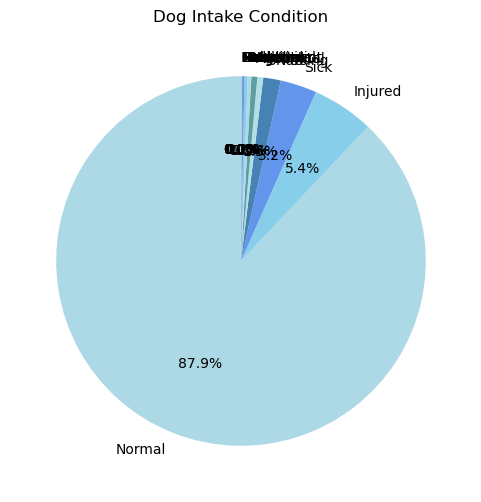

Missing: 0


In [43]:
# SEGMENTED BY ANIMAL TYPE

# Define custom color palettes
cat_colors = ['#ffc0cb', '#ff9999', '#ffcccb', '#ffb6c1', '#e75480', '#ffa07a']
dog_colors = ['#add8e6', '#87ceeb', '#6495ed', '#4682b4', '#b0e0e6', '#5f9ea0']

# SEGMENTED BY ANIMAL TYPE

# CAT INTAKE CONDITION
print("CAT INTAKE CONDITIONS")
print(df_cat['intake_condition'].value_counts())
plt.figure(figsize=(6, 6))
plt.pie(df_cat['intake_condition'].value_counts(),
        labels=df_cat['intake_condition'].value_counts().index,
        autopct='%1.1f%%',
        startangle=90,
        colors=cat_colors)
plt.title('Cat Intake Condition')
plt.show()
print("Missing:", df_cat['intake_condition'].isna().sum())

# DOG INTAKE CONDITION
print("DOG INTAKE CONDITIONS")
print(df_dog['intake_condition'].value_counts())
plt.figure(figsize=(6, 6))
plt.pie(df_dog['intake_condition'].value_counts(),
        labels=df_dog['intake_condition'].value_counts().index,  # corrected this line!
        autopct='%1.1f%%',
        startangle=90,
        colors=dog_colors)
plt.title('Dog Intake Condition')
plt.show()
print("Missing:", df_dog['intake_condition'].isna().sum())

In [44]:
#  Intake Type v Intake Condition

pd.crosstab(df_train['intake_type'], df_train['intake_condition'])

intake_condition,0,Aged,Agonal,Behavior,Congenital,Feral,Injured,Med Attn,Med Urgent,Medical,Neonatal,Neurologic,Normal,Nursing,Other,Parvo,Pregnant,Sick,Space,Unknown
intake_type,,,,,,,,,,,,,,,,,,,,
0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Abandoned,0,0,0,0,0,0,19,0,0,12,74,0,1017,61,1,0,0,47,2,0
Euthanasia Request,0,29,0,0,0,0,12,0,1,0,0,0,65,0,1,0,0,74,0,0
Owner Surrender,0,85,1,16,0,6,523,12,2,45,102,1,19492,204,75,0,20,858,0,4
Public Assist,0,30,0,12,0,1,155,0,0,31,27,0,5592,96,36,0,4,145,0,2
Stray,0,229,0,14,1,97,5685,36,4,210,1037,9,68839,2596,134,5,87,3170,0,6
Wildlife,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


These are the Intake Types Among the Animals Found Outside Jurisdiction intake_type
Owner Surrender       539
Stray                 327
Public Assist         169
Abandoned              13
Euthanasia Request      1
Name: count, dtype: int64 

These are the Intake Conditions Among the Animals Found Outside Jurisdiction intake_condition
Normal        932
Injured        47
Sick           32
Nursing        17
Neonatal       15
Medical         3
Pregnant        1
Aged            1
Neurologic      1
Name: count, dtype: int64 

cities animals were found city_name
Austin (TX)             90573
Travis (TX)             12741
Manor (TX)               2322
Valle (TX)               1671
Pflugerville (TX)        1462
Outside Jurisdiction     1047
Leander (TX)              257
Vista (TX)                161
Park (TX)                 125
Lakeway (TX)              118
Creedmoor (TX)            118
Jonestown (TX)             98
Ridge (TX)                 77
Hays (TX)                  68
Rock (TX)         

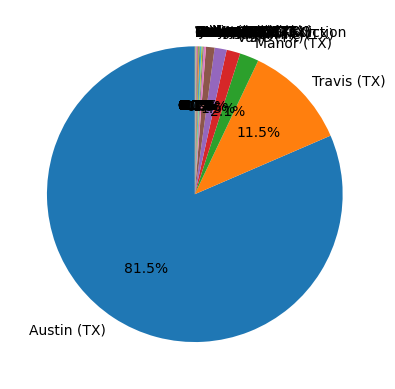

intake_type,0,Abandoned,Euthanasia Request,Owner Surrender,Public Assist,Stray,Wildlife
city_name,,,,,,,
,4,0,0,0,0,0,0
Austin (TX),0,1093,162,16964,4945,67408,1
Bastrop (TX),0,0,0,25,0,32,0
Blanco (TX),0,0,0,1,0,0,0
Burnet (TX),0,0,0,4,0,1,0
Caldwell (TX),0,0,0,4,2,4,0
Cave (TX),0,0,0,15,5,32,0
Creedmoor (TX),0,0,0,23,4,91,0
Hays (TX),0,1,0,30,5,32,0


In [ ]:
# Found Location
# df_train.sample(50)

# number of rows that did NOT find the pet in Austin, TX
df_no_austin = df_train[~df_train['found_location'].str.contains('Austin', case=False, na=False)]
df_no_austin.shape[0]

# these are the rows that were found outside juridiction
df_outside = df_no_austin[df_no_austin['found_location'].str.contains('Outside', case=False, na=False)]
print('These are the Intake Types Among the Animals Found Outside Jurisdiction', df_outside['intake_type'].value_counts(), "\n")
print('These are the Intake Conditions Among the Animals Found Outside Jurisdiction', df_outside['intake_condition'].value_counts(), "\n")

pd.crosstab(df_outside['intake_type'], df_outside['intake_condition'])


# looking at the city names - will not keep city names
df_train['city_name'] = df_train['found_location'].apply(
    lambda x: ' '.join(x.split()[-2:]) if isinstance(x, str) else ''
)
print('cities animals were found', df_train['city_name'].value_counts())
plt.pie(df_train['city_name'].value_counts(), labels=df_train['city_name'].value_counts().index, autopct='%1.1f%%', startangle=90)
plt.show()
pd.crosstab(df_train['city_name'], df_train['intake_type'])

In [ ]:
# MORE FOUND LOCATION (wanted to make it neater)
df_i35 = df_train[df_train['found_location'].str.contains(' 35 ')]
print('These are the Intake Types Among the Animals Found on the Interstate Hwy 35', df_i35['intake_type'].value_counts(), "\n")
print('These are the Intake Conditions Among the Animals on the Interstate Hwy 35', df_i35['intake_condition'].value_counts(), "\n")

In [ ]:
import re

def extract_street(location):
    if pd.isna(location):
        return None
    
    # Remove anything like "in Austin (TX)" or "Austin (TX)" at the end
    cleaned = re.sub(r'in Austin.*|Austin\s*\(TX\).*', '', location, flags=re.IGNORECASE).strip()
    
    # Remove leading numbers (e.g. "3522 " from "3522 East MLK Blvd")
    cleaned = re.sub(r'^\d+\s+', '', cleaned)
    
    return cleaned if cleaned else None



In [ ]:
df_train['street_name'] = df_train['found_location'].apply(extract_street)

# Set pandas options to display the entire content of each column
pd.set_option('display.max_colwidth', None)  # No truncation for strings
pd.set_option('display.max_rows', None)  # Show all rows (if not too many)


df_train['street_name'] = df_train['found_location'].apply(extract_street)
print(df_train['street_name'].value_counts())

In [ ]:
# Found Location by Highways
df_hwy = df_train[(df_train['found_location'].str.contains('evander', case=False, na=False)) | (df_train['found_location'].str.contains(' 35 ', case=False, na=False)) | (df_train['found_location'].str.contains('opac', case=False, na=False))]

print(df_hwy.shape[0])
print('These are the Intake Types Among the Animals Found on Highways', df_hwy['intake_type'].value_counts(), "\n")
print('These are the Intake Conditions Among the Animals on Highways', df_hwy['intake_condition'].value_counts(), "\n")

print("These are the number of Pets found on Street Corners")
df_train[(df_train['found_location'].str.contains('and', case=False, na=False)) | (df_train['found_location'].str.contains('&', case=False, na=False)) | (df_train['found_location'].str.contains('And', case=False, na=False))].shape[0]


In [ ]:

print("Number of Names with a * In It")
print(df_train[df_train['name'].str.contains(r'\*', na=False)].shape[0])


print('Number of Names with a Parentheses in It')
df_train[df_train['name'].str.contains(r'\(', na=False)]

In [ ]:
print('Number of Names That Have More Than One Word')
df_train['num_words'] = df_train['name'].str.split().str.len() # takes a long time to dp
df_train


plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(df_train['num_words'], bins=range(int(df_train['num_words'].min()), int(df_train['num_words'].max()) + 2), color='skyblue', edgecolor='black')

# Add numbers on top of the bars
for count, bin_left in zip(counts, bins):
    if count > 0:  # Only add text for bins that have counts
        plt.text(bin_left + 0.2, count, str(int(count)), fontsize=10, color='black')

# Set integer labels on x-axis
plt.xticks(range(int(df_train['num_words'].min()), int(df_train['num_words'].max()) + 1))

plt.title('Distribution of Number of Words per Name')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [ ]:
# Finally onto name
food  = pd.read_csv('generic-food.csv')
food = food.drop(food.columns[1:], axis=1)
food.columns

matching_names = df_train[df_train['name'].apply(lambda x: any(food_name.lower() in str(x).lower() for food_name in food['FOOD NAME']))]

In [ ]:
# Count the number of matching names
matching_names.shape[0]
print('These are the names that also match with the food CSV')
print(matching_names['name'].value_counts(), "\n")

print('These are the animals that have a number in them')
print(df_train['name'][df_train['name'].str.contains(r'[^a-zA-Z ()*]', na=False)], "\n")


In [ ]:
pd.crosstab(df_outside['intake_type'], df_outside['outcome_type'])

In [ ]:
#df_train.sample(15)
#print('These are the animals that have a number in them')
df_train[df_train['name'].str.contains(r'[^a-zA-Z ().*-]', na=False)]